In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from geometry import *
from materials import *
from inputs import *

In [2]:
#plt.figure(figsize = (20,2))
#plt.imshow(np.flipud(np.transpose(Tinit([])[:,16,:])))
#plt.imshow(np.flipud(np.transpose(alphas([],0)[:,16,:,1])))

In [3]:
print(alpha_cfo)
print(r_cfo)

0.000847953216374269
0.16666666666666663


In [4]:
print(alpha_aln)
print(r_aln)

7.250755287009064e-05
0.014251484529638503


In [5]:
print(alphas[0])
print(r_ins[0])

[8.e-05]
[0.01572414]


In [6]:
def alphas(T):
    grid = np.zeros((gridx,gridy,gridz,3)) #0*Tinit(thicks) # alpha is zero wherever there is no material    
    grid[foamx[0]:foamx[1],foamy[0]:foamy[1],foamz[0]:foamz[1],0:3] = r_cfo # carbon foam    
    grid[fiberx[0]:fiberx[1],fibery[0]:fibery[1],fiberz[0]:fiberz[1],0:1] = r_cfi[0]# carbon fiber
    grid[fiberx[0]:fiberx[1],fibery[0]:fibery[1],fiberz[0]:fiberz[1],1:2] = r_cfi[1]# carbon fiber
    grid[fiberx[0]:fiberx[1],fibery[0]:fibery[1],fiberz[0]:fiberz[1],2:3] = r_cfi[2]# carbon fiber
    
    grid[inx[0]:inx[1],iny[0]:iny[1],fiberz[0]:fiberz[1],0:3] = r_aln
    
    # input materials
    for i in range(int(len(thicks))):
        grid[inx[0]:inx[1],iny[0]:iny[1],inz[0]+sum(thicks[0:i]):inz[0]+sum(thicks[0:i+1]),0:3] = r_ins[i]    
    for i in range(glassx[0],glassx[1]):
        for j in range(glassy[0],glassy[1]):
            for k in range(glassz[0],glassz[1]):
                grid[i][j][k] = r_glass_T(T[i][j][k])
    for i in range(six[0],six[1]):
        for j in range(siy[0],siy[1]):
            for k in range(siz[0],siz[1]):
                grid[i][j][k] = r_si_T(T[i][j][k])
    return grid

In [7]:
@jit(nopython=True) # update shape in rectangular prism form
def Tupdatetube(Tgrid):
    Tgridn = Tgrid
    for l in list(range(ctb1x-tr, ctb1x+tr+1)) + list(range(ctb2x-tr, ctb2x+tr+1)): # loop over possible x-values of tube
        for m in range(ctbz-tr,ctbz+tr+1): # loop over possible z-values of tube
            if (min((l-ctb1x)**2,(l-ctb2x)**2)+(m-ctbz)**2 <= tr**2): # if the pixel is in either tube
                Tgridn[l:l+1,0:Tgrid.shape[1]-1,m:m+1]=tt # set temperature to tube temperature   
    return Tgridn

In [8]:
def Tinit(): # creates a grid with features of heat source and cold tube points    
    grid = at*np.ones((gridx,gridy,gridz)) # establish grid    
    grid = Tupdatetube(grid) # initialize tubing temperatures
    return grid

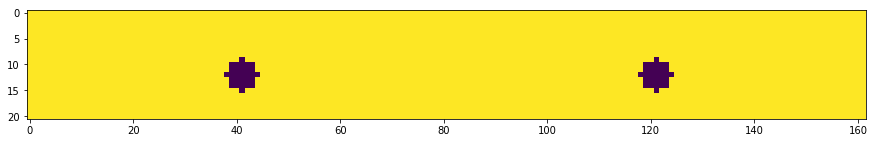

In [9]:
TCS = Tinit()
plt.figure(figsize = (20,2))
plt.imshow(np.flipud(np.transpose(TCS[:,16,:])))

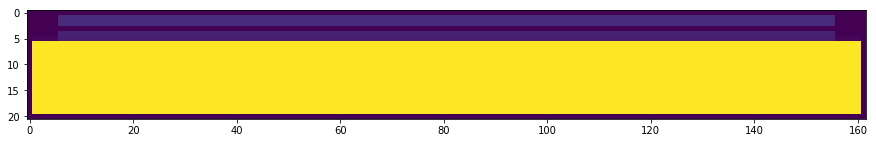

In [10]:
RCS = alphas(Tinit())
plt.figure(figsize = (20,2))
plt.imshow(np.flipud(np.transpose(RCS[:,16,:,0])))

In [11]:
@jit(nopython=True)
def wavg(grid, alphas, i1, i2, i3):
    return grid[i1][i2][i3]+alphas[i1+1][i2][i3][0]*(grid[i1+1][i2][i3]-grid[i1][i2][i3])+alphas[i1-1][i2][i3][0]*(grid[i1-1][i2][i3]-grid[i1][i2][i3])+alphas[i1][i2+1][i3][1]*(grid[i1][i2+1][i3]-grid[i1][i2][i3])+alphas[i1][i2-1][i3][1]*(grid[i1][i2-1][i3]-grid[i1][i2][i3])+alphas[i1][i2][i3+1][2]*(grid[i1][i2][i3+1]-grid[i1][i2][i3])+alphas[i1][i2][i3-1][2]*(grid[i1][i2][i3-1]-grid[i1][i2][i3])

In [12]:
@jit(nopython=True) # update shape in rectangular prism form
def Tupdaterectp(Tgrid, alphagrid, x0, x1, y0, y1, z0, z1, p):
    Tgridn = Tgrid
    for i in range(x0,x1):
        for j in range(y0,y1):
            for k in range(z0,z1):
                Tgridn[i][j][k] = wavg(Tgrid, alphagrid, i, j, k)+p  
    return Tgridn

In [13]:
@jit(nopython=True)
def Tupdate(Tgrid, alphagrid, pain): 
    Tgridn = Tgrid
    Tgridn = Tupdaterectp(Tgrid, alphagrid, 1, Tgrid.shape[0]-1, 1, Tgrid.shape[1]-1, foamz0, foamz1, 0)
    Tgridn = Tupdaterectp(Tgrid, alphagrid, 1, Tgrid.shape[0]-1, 1, Tgrid.shape[1]-1, fiberz0, fiberz1, 0)
    Tgridn = Tupdaterectp(Tgrid, alphagrid, inx0, inx1, iny0, iny1, inz0, inz1, 0)
    Tgridn = Tupdaterectp(Tgrid, alphagrid, inx0, inx1, iny0, iny1, glassz0, glassz1, 0)
    Tgridn = Tupdaterectp(Tgrid, alphagrid, inx0, inx1, iny0, iny1-hsw, siz0, siz1, (1-mpsr)*pain*vmod/(vmod-vshunt))
    Tgridn = Tupdaterectp(Tgrid, alphagrid, inx0, inx1, iny1-hsw, iny1, siz0, siz1, mpsr*pain*vmod/vshunt)
    Tgridn = Tupdatetube(Tgrid) # update tubes
    return Tgridn

In [14]:
def progressBar(current, total, barLength = 20):
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))
    print('Progress: [%s%s] %d %%' % (arrow, spaces, percent), end='\r')

In [15]:
# calculates power added to silicon at every iteration
ptot = 15 # watts
eadd = dt*ptot/(deltad**3*vmod)
pai = eadd/(dens_si*cp_si)
print(pai)

0.00033152203651404645


In [16]:
print(np.floor(0.05/dt))
print(1000*dt)

2826.0
0.017689655172413787


In [17]:
def final_diff(tlength, trupdate, ptot):
    #ptot = 0.12537 # watts
    eadd = dt*ptot/(deltad**3*vmod)
    pai = eadd/(dens_si*cp_si)
    tlen = int(np.floor(tlength/dt))
    timeseries = np.zeros(ts)
    T = Tinit()
    A = alphas(T)
    timeseries = np.zeros(tlen)
    for h in range(tlen):
        timeseries[h]=np.mean(T[six[0]:six[1],siy[0]:siy[1],siz[0]:siz[1]])
        T = Tupdate(T, A, pai)
        if np.mod(h,np.floor(trupdate/dt)) == 0:
            A = alphas(T)
        progressBar(h+1, tlen)
    return (timeseries[-1]-timeseries[-2])/dt

In [27]:
tlen = int(np.floor(0.35/dt))
timeseries = np.zeros(ts)
T = Tinit()
A = alphas(T)
timeseries = np.zeros(tlen)
for h in range(tlen):
    timeseries[h]=np.mean(T[six[0]:six[1],siy[0]:siy[1],siz[0]:siz[1]])
    T = Tupdate(T, A, pai)
    if np.mod(h,np.floor(0.05/dt)) == 0:
        A = alphas(T)
    progressBar(h+1, tlen)

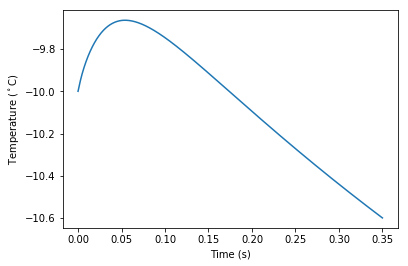

In [19]:
x = np.linspace(0,tlen*dt,tlen)
plt.plot(x,timeseries)
plt.xlabel('Time (s)')
plt.ylabel('Temperature ($^\circ$C)')
plt.show()

In [20]:
initmax = 22
initmin = 11
# make it output errors
for i in range(20):
    initmid = np.mean([initmin,initmax])
    print(initmid)
    cand = np.round(final_diff(0.35, 0.05, initmid),8) 
    if cand < 0:
        initmin = initmid
    elif cand > 0:
        initmax = initmid
    else:
        break

16.5
19.25ess: [------------------->] 100 %
17.875ss: [------------------->] 100 %
18.5625s: [------------------->] 100 %
18.90625: [------------------->] 100 %
18.734375 [------------------->] 100 %
18.8203125[------------------->] 100 %
18.77734375------------------->] 100 %
18.755859375------------------>] 100 %
18.7451171875----------------->] 100 %
18.73974609375---------------->] 100 %
18.742431640625--------------->] 100 %
18.7437744140625-------------->] 100 %
18.74310302734375------------->] 100 %
18.742767333984375------------>] 100 %
18.742599487304688------------>] 100 %
18.742515563964844------------>] 100 %
18.742473602294922------------>] 100 %
18.742494583129883------------>] 100 %
18.742484092712402------------>] 100 %


In [21]:
# assembly 1: alpha = .00002: 3.6117
# assembly 1: alpha = .00004: 6.6970
# assembly 1: alpha = .00006: 9.3599
# assembly 1: alpha = .00008: 11.67811
# assembly 1: alpha = .0001: 13.71105

In [22]:
# assembly 2: alpha = .00002: 6.7148
# assembly 2: alpha = .00004: 11.7364
# assembly 2: alpha = .00006: 15.6326
# assembly 2: alpha = .00008: 18.74248
# assembly 2: alpha = .0001: 21.2814

In [ ]:
# assembly 3: alpha = .00002: 1.6668
# assembly 3: alpha = .00004: 3.9554
# assembly 3: alpha = .00006: 6.0506
# assembly 3: alpha = .00008: 7.9818
# assembly 3: alpha = .0001: 9.4980